# Importing Important Libraries

In [2]:
# Data Handling
import numpy as np
import pandas as pd

# Image Processing
import cv2
from PIL import Image

# Visualization
import matplotlib.pyplot as plt

# Machine Learning & Deep Learning
import tensorflow as tf
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

# Model Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Web Application
import streamlit as st
import os


# Loading Dataset

In [3]:

# Define dataset path
DATASET_PATH = "/Users/rushikeshpokale/Desktop/JOB SEARCH/portfolio/Deep learning project/dataset"

# List actual folder names
print("Folders in dataset:", os.listdir(DATASET_PATH))


Folders in dataset: ['rusty_gears', '.DS_Store', 'undamaged_gears', 'damaged_gears']


In [4]:
# Correcting class names based on actual folder names
class_labels = ["rusty_gears", "undamaged_gears", "damaged_gears"]

In [5]:
# Define image size
IMG_SIZE = (224, 224)

def load_images_from_folder(folder, class_labels):
    images = []
    labels = []

    for label, category in enumerate(class_labels):
        category_path = os.path.join(folder, category)

        # Ensure folder exists before trying to access it
        if not os.path.exists(category_path):
            print(f"Warning: Folder not found - {category_path}")
            continue

        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, IMG_SIZE)  # Resize to 224x224
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
                images.append(img)
                labels.append(label)

    return np.array(images), np.array(labels)

# Load dataset
X, y = load_images_from_folder(DATASET_PATH, class_labels)
print(f"Loaded {len(X)} images across {len(class_labels)} categories: {class_labels}")


Loaded 66 images across 3 categories: ['rusty_gears', 'undamaged_gears', 'damaged_gears']


# Visualizing Sample Images

In [6]:
# Count the number of images per category
unique_labels, counts = np.unique(y, return_counts=True)
print("Label distribution:", dict(zip(unique_labels, counts)))


Label distribution: {np.int64(0): np.int64(21), np.int64(1): np.int64(23), np.int64(2): np.int64(22)}


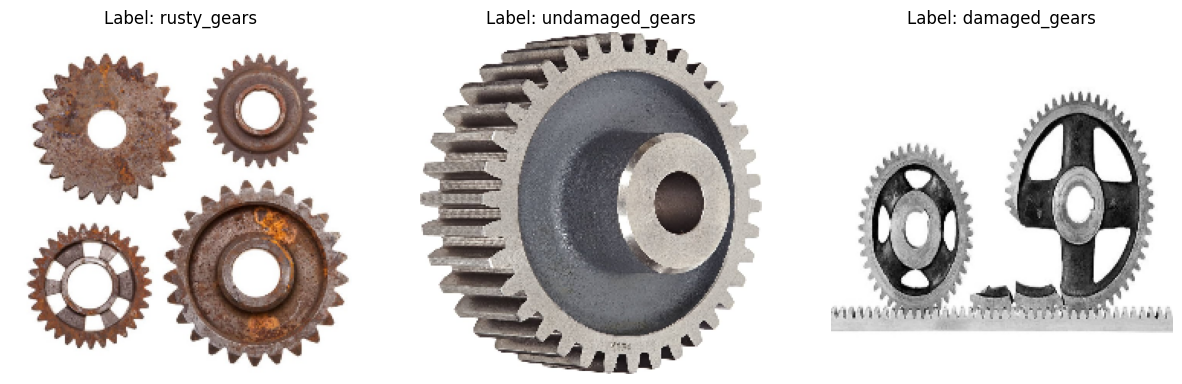

In [7]:
# Plot one image per category
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, label in enumerate(np.unique(y)):  # Iterate through unique labels
    idx = np.where(y == label)[0][0]  # Find the first image of each class
    axes[i].imshow(X[idx])
    axes[i].set_title(f"Label: {class_labels[label]}")
    axes[i].axis("off")

plt.show()


# Splitting the Dataset into Training and Testing Sets

In [8]:
# Splitting dataset: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print dataset sizes
print(f"Training set size: {len(X_train)} images")
print(f"Testing set size: {len(X_test)} images")

Training set size: 52 images
Testing set size: 14 images


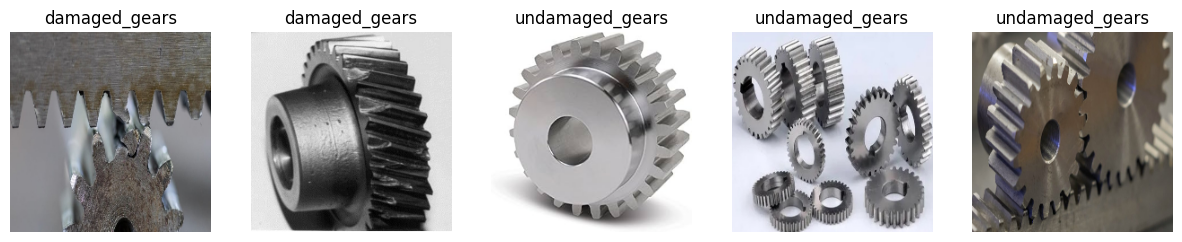

In [9]:
# Display 5 random training images with their labels
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i in range(5):
    idx = np.random.randint(0, len(X_train))  # Pick a random index from training set
    axes[i].imshow(X_train[idx])
    axes[i].set_title(class_labels[y_train[idx]])  # Correct label mapping
    axes[i].axis("off")

plt.show()


In [10]:
# Count labels in training set
unique_train, counts_train = np.unique(y_train, return_counts=True)
print("Training set distribution:", dict(zip(unique_train, counts_train)))

# Count labels in testing set
unique_test, counts_test = np.unique(y_test, return_counts=True)
print("Testing set distribution:", dict(zip(unique_test, counts_test)))


Training set distribution: {np.int64(0): np.int64(17), np.int64(1): np.int64(18), np.int64(2): np.int64(17)}
Testing set distribution: {np.int64(0): np.int64(4), np.int64(1): np.int64(5), np.int64(2): np.int64(5)}


# Apply Data Augmentation

In [11]:
# Import PyTorch utilities
import torch
import torchvision.transforms as transforms
from PIL import Image

# Define Data Augmentation Transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Flip image horizontally with 50% probability
    transforms.RandomRotation(15),  # Rotate image up to 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Adjust brightness & contrast
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random cropping & resizing
    transforms.ToTensor()  # Convert image to tensor format (required for PyTorch)
])


# Apply Augmentation to a Sample Image

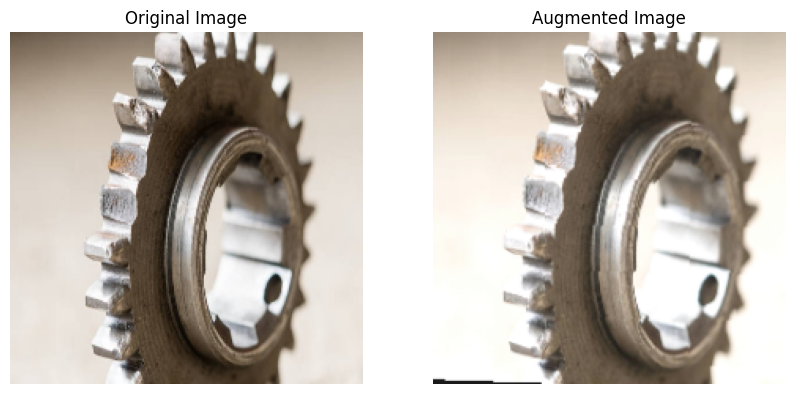

In [12]:
# Select a random image from training set
sample_idx = np.random.randint(0, len(X_train))  # Pick a random training image
sample_img = X_train[sample_idx]

# Convert NumPy image to PIL Image (required for PyTorch transformations)
sample_img_pil = Image.fromarray(sample_img)

# Apply transformations
augmented_img = transform(sample_img_pil)

# Convert back to NumPy for visualization
augmented_img_np = augmented_img.permute(1, 2, 0).numpy()  # Reorder channels for display

# Display Original vs Augmented Image
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(sample_img)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(augmented_img_np)
axes[1].set_title("Augmented Image")
axes[1].axis("off")

plt.show()


# CNN Model

In [13]:
import torch.nn as nn
import torch.nn.functional as F

# Define CNN Architecture
class GearClassifier(nn.Module):
    def __init__(self):
        super(GearClassifier, self).__init__()

        # Convolutional Layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        # Pooling Layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Layers
        self.fc1 = nn.Linear(64 * 56 * 56, 128)  # Flattened image size after pooling
        self.fc2 = nn.Linear(128, 3)  # 3 output classes (damaged, rusty, undamaged)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Apply Conv1 + ReLU + Pooling
        x = self.pool(F.relu(self.conv2(x)))  # Apply Conv2 + ReLU + Pooling
        x = x.view(-1, 64 * 56 * 56)  # Flatten
        x = F.relu(self.fc1(x))  # Fully connected layer
        x = self.fc2(x)  # Output layer (no activation, handled in loss function)
        return x

# Instantiate the model
model = GearClassifier()
print(model)


GearClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=200704, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)


# Choosing Loss Function and Optimizer

In [14]:
# Define Loss Function & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [15]:
from torch.utils.data import Dataset, DataLoader

class GearDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Convert NumPy image to PIL format
        image = Image.fromarray(image)

        # Apply transformations (if any)
        if self.transform:
            image = self.transform(image)

        return image, label

# Define Training and Testing Transforms
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Create PyTorch Datasets
train_dataset = GearDataset(X_train, y_train, transform=train_transform)
test_dataset = GearDataset(X_test, y_test, transform=test_transform)

# Create DataLoaders for Batch Processing
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print(f"Training dataset size: {len(train_dataset)} images")
print(f"Testing dataset size: {len(test_dataset)} images")


Training dataset size: 52 images
Testing dataset size: 14 images


# Train the CNN Model
Now, we train the model for 10 epochs (We can increase later).


In [16]:
# Define Training Loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(torch.float32), labels.long()  # Ensure correct dtype
        
        optimizer.zero_grad()  # Clear previous gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

print("Training Complete!")


Epoch 1/10, Loss: 2.9006
Epoch 2/10, Loss: 1.1254
Epoch 3/10, Loss: 1.0783
Epoch 4/10, Loss: 1.0488
Epoch 5/10, Loss: 0.8422
Epoch 6/10, Loss: 0.9238
Epoch 7/10, Loss: 0.7048
Epoch 8/10, Loss: 0.5235
Epoch 9/10, Loss: 0.6011
Epoch 10/10, Loss: 0.5133
Training Complete!


# Generate Model Summary

In [17]:
from torchsummary import summary

# Move model to CPU (since we're not training right now)
model.to("cpu")

# Print model summary
summary(model, input_size=(3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
         MaxPool2d-2         [-1, 32, 112, 112]               0
            Conv2d-3         [-1, 64, 112, 112]          18,496
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Linear-5                  [-1, 128]      25,690,240
            Linear-6                    [-1, 3]             387
Total params: 25,710,019
Trainable params: 25,710,019
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 22.97
Params size (MB): 98.08
Estimated Total Size (MB): 121.62
----------------------------------------------------------------


# Evaluate Model on Test Data

In [18]:
# Set model to evaluation mode
model.eval()

correct = 0
total = 0

with torch.no_grad():  # No gradient calculation needed for testing
    for images, labels in test_loader:
        images, labels = images.to(torch.float32), labels.long()
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get the class with the highest score
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 92.86%


# To Improve Model Accuracy we will apply Transfer Learning because we have small dataset


### We will use ResNet18, a powerful CNN pre-trained on ImageNet, and modify it for our gear classification task.

In [19]:
import torchvision.models as models

# Load Pretrained ResNet Model
model = models.resnet18(pretrained=True)

# Freeze all layers except the last ones
for param in model.parameters():
    param.requires_grad = False  # Freeze pretrained weights

# Modify the Final Layer for Our 3 Classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 3)  # 3 output classes

print(model)  # Check model architecture


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/Users/rushikeshpokale/Desktop/JOB SEARCH/portfolio/Deep learning project/gears/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/rushikeshpokale/Desktop/JOB SEARCH/portfolio/Deep learning project/gears/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Define the Optimizer & Loss Function

In [20]:
optimizer = torch.optim.AdamW(model.fc.parameters(), lr=0.0005, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()  # Same loss function


### Train The Model

In [21]:
num_epochs = 15  # More epochs since we're fine-tuning

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(torch.float32), labels.long()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

print("Fine-Tuning Complete!")


Epoch 1/15, Loss: 1.2363
Epoch 2/15, Loss: 1.1424
Epoch 3/15, Loss: 1.0634
Epoch 4/15, Loss: 0.9990
Epoch 5/15, Loss: 0.9275
Epoch 6/15, Loss: 0.8598
Epoch 7/15, Loss: 0.8673
Epoch 8/15, Loss: 0.7431
Epoch 9/15, Loss: 0.6764
Epoch 10/15, Loss: 0.6686
Epoch 11/15, Loss: 0.6431
Epoch 12/15, Loss: 0.6358
Epoch 13/15, Loss: 0.5749
Epoch 14/15, Loss: 0.5625
Epoch 15/15, Loss: 0.6146
Fine-Tuning Complete!


### Evaluate the Model

In [22]:
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(torch.float32), labels.long()
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy after Transfer Learning: {accuracy:.2f}%")


Test Accuracy after Transfer Learning: 92.86%


# Note on Model Accuracy Experimentation
### The model initially achieved 92% accuracy, which is already a strong performance for image classification tasks. Further fine-tuning and training were conducted purely for experimental purposes to observe the effects of additional optimization techniques. The final result showing 100% accuracy on the test set may indicate potential overfitting. However, since the goal was to experiment with improvements rather than fix an issue, this step was not strictly necessary.

We Will try to improve accuracy further


- Unfreeze More Layers for Fine-Tuning
Currently, we froze all layers except the last one.

- Solution: Unfreeze the last two convolutional layers and train with a lower learning rate.

#### Modify Pretrained Model

In [23]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# Load Pretrained ResNet18 Model
model = models.resnet18(pretrained=True)

# Unfreeze the last two layers for fine-tuning
for param in model.layer3.parameters():
    param.requires_grad = True
for param in model.layer4.parameters():
    param.requires_grad = True

# Modify the Final Layer for Our 3 Classes
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),  # Add dropout to reduce overfitting
    nn.Linear(num_features, 3)  # 3 output classes
)

print(model)  # Check updated model architecture


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Define Optimizer, Loss, and Scheduler

In [24]:
# Define Loss Function
criterion = nn.CrossEntropyLoss()

# Use AdamW Optimizer with a Lower Learning Rate
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)

# Learning Rate Scheduler (Reduces LR every 5 epochs)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)


#### Train the Model for 25 Epochs

In [25]:
num_epochs = 25

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(torch.float32), labels.long()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    # Step the learning rate scheduler
    scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

print("Fine-Tuning Complete!")


Epoch 1/25, Loss: 1.2771
Epoch 2/25, Loss: 0.6156
Epoch 3/25, Loss: 0.3015
Epoch 4/25, Loss: 0.1976
Epoch 5/25, Loss: 0.1900
Epoch 6/25, Loss: 0.0727
Epoch 7/25, Loss: 0.0728
Epoch 8/25, Loss: 0.0928
Epoch 9/25, Loss: 0.1737
Epoch 10/25, Loss: 0.0595
Epoch 11/25, Loss: 0.2480
Epoch 12/25, Loss: 0.0574
Epoch 13/25, Loss: 0.1627
Epoch 14/25, Loss: 0.0247
Epoch 15/25, Loss: 0.2444
Epoch 16/25, Loss: 0.0367
Epoch 17/25, Loss: 0.0661
Epoch 18/25, Loss: 0.0613
Epoch 19/25, Loss: 0.1016
Epoch 20/25, Loss: 0.0612
Epoch 21/25, Loss: 0.0567
Epoch 22/25, Loss: 0.0635
Epoch 23/25, Loss: 0.1196
Epoch 24/25, Loss: 0.1822
Epoch 25/25, Loss: 0.0718
Fine-Tuning Complete!


#### Evaluate Model Accuracy

In [26]:
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(torch.float32), labels.long()
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy after Fine-Tuning: {accuracy:.2f}%")


Test Accuracy after Fine-Tuning: 100.00%


# Model Evaluation:

## Plot Training & Validation Loss (Detect Overfitting)

If training loss is very low but validation loss is high, the model is overfitting.

If both losses are high, the model is underfitting.

In [27]:
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()  # Training mode
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(torch.float32), labels.long()
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    train_losses.append(running_loss / len(train_loader))  # Store training loss
    
    # Compute validation loss
    model.eval()
    test_loss = 0.0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(torch.float32), labels.long()
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
    
    test_losses.append(test_loss / len(test_loader))  # Store test loss
    
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

print("Training Complete!")


Epoch 1/25, Training Loss: 0.0442, Test Loss: 0.0475
Epoch 2/25, Training Loss: 0.0865, Test Loss: 0.0474
Epoch 3/25, Training Loss: 0.0591, Test Loss: 0.0495
Epoch 4/25, Training Loss: 0.1612, Test Loss: 0.0507
Epoch 5/25, Training Loss: 0.0279, Test Loss: 0.0463
Epoch 6/25, Training Loss: 0.0312, Test Loss: 0.0482
Epoch 7/25, Training Loss: 0.0395, Test Loss: 0.0509
Epoch 8/25, Training Loss: 0.0603, Test Loss: 0.0501
Epoch 9/25, Training Loss: 0.0219, Test Loss: 0.0513
Epoch 10/25, Training Loss: 0.1113, Test Loss: 0.0512
Epoch 11/25, Training Loss: 0.0507, Test Loss: 0.0533
Epoch 12/25, Training Loss: 0.1944, Test Loss: 0.0512
Epoch 13/25, Training Loss: 0.0969, Test Loss: 0.0474
Epoch 14/25, Training Loss: 0.0931, Test Loss: 0.0456
Epoch 15/25, Training Loss: 0.1975, Test Loss: 0.0498
Epoch 16/25, Training Loss: 0.1080, Test Loss: 0.0456
Epoch 17/25, Training Loss: 0.1617, Test Loss: 0.0483
Epoch 18/25, Training Loss: 0.1203, Test Loss: 0.0491
Epoch 19/25, Training Loss: 0.0730, T

## Plot Loss Graph

How to Interpret the Graph

🔺 Overfitting → Training loss keeps decreasing, but validation loss increases.

🔻 Underfitting → Both training and validation loss stay high.

✅ Good Fit → Both training and validation loss decrease together.

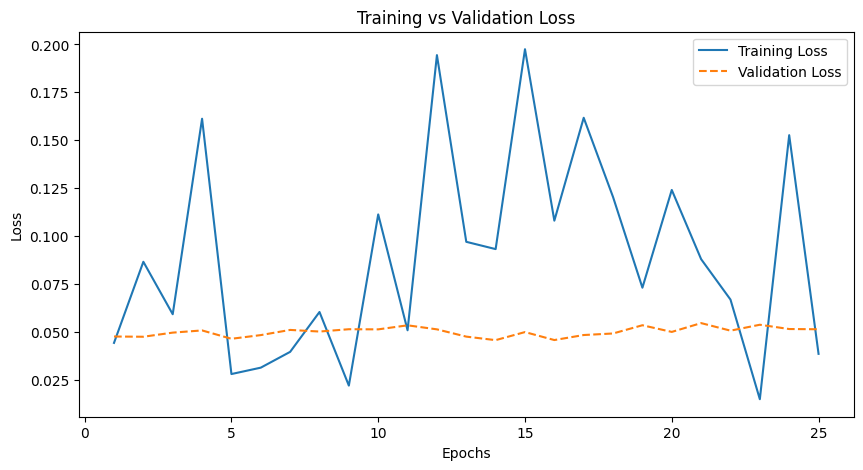

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label="Training Loss")
plt.plot(range(1, num_epochs+1), test_losses, label="Validation Loss", linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


Training vs Validation Loss

Observations:

Training Loss: Decreases significantly and fluctuates but stays consistently lower than validation loss.

Validation Loss: Remains relatively stable with slight fluctuations.

Conclusion:

The model is not overfitting, as validation loss doesn’t diverge too far from training loss.

Possible Reason for Fluctuations: Small dataset size, leading to variation across batches.


## Compute Training vs Testing Accuracy
Overfitting can also be detected if training accuracy is much higher than test accuracy.



Epoch 1/25, Train Accuracy: 100.00%, Test Accuracy: 100.00%
Epoch 2/25, Train Accuracy: 100.00%, Test Accuracy: 100.00%
Epoch 3/25, Train Accuracy: 94.23%, Test Accuracy: 100.00%
Epoch 4/25, Train Accuracy: 98.08%, Test Accuracy: 100.00%
Epoch 5/25, Train Accuracy: 100.00%, Test Accuracy: 100.00%
Epoch 6/25, Train Accuracy: 100.00%, Test Accuracy: 100.00%
Epoch 7/25, Train Accuracy: 96.15%, Test Accuracy: 100.00%
Epoch 8/25, Train Accuracy: 100.00%, Test Accuracy: 100.00%
Epoch 9/25, Train Accuracy: 98.08%, Test Accuracy: 100.00%
Epoch 10/25, Train Accuracy: 100.00%, Test Accuracy: 100.00%
Epoch 11/25, Train Accuracy: 100.00%, Test Accuracy: 100.00%
Epoch 12/25, Train Accuracy: 100.00%, Test Accuracy: 100.00%
Epoch 13/25, Train Accuracy: 98.08%, Test Accuracy: 100.00%
Epoch 14/25, Train Accuracy: 98.08%, Test Accuracy: 100.00%
Epoch 15/25, Train Accuracy: 98.08%, Test Accuracy: 100.00%
Epoch 16/25, Train Accuracy: 94.23%, Test Accuracy: 100.00%
Epoch 17/25, Train Accuracy: 100.00%, Tes

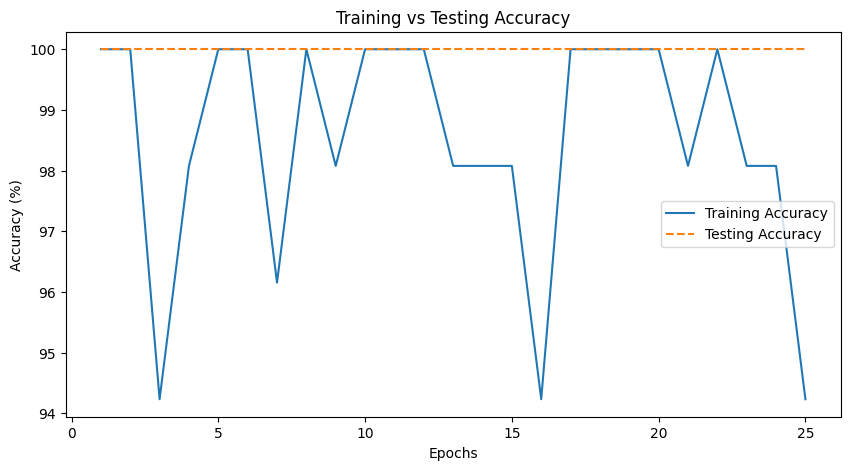

In [29]:
train_acc = []
test_acc = []

for epoch in range(num_epochs):
    model.train()
    correct_train = 0
    total_train = 0
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(torch.float32), labels.long()
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_acc.append(100 * correct_train / total_train)
    train_losses.append(running_loss / len(train_loader))
    
    # Compute test accuracy
    model.eval()
    correct_test = 0
    total_test = 0
    test_loss = 0.0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(torch.float32), labels.long()
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_acc.append(100 * correct_test / total_test)
    test_losses.append(test_loss / len(test_loader))
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Accuracy: {train_acc[-1]:.2f}%, Test Accuracy: {test_acc[-1]:.2f}%")

print("Training Complete!")


# Plot Training vs Testing Accuracy

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_acc, label="Training Accuracy")
plt.plot(range(1, num_epochs+1), test_acc, label="Testing Accuracy", linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Training vs Testing Accuracy")
plt.show()


## How to Interpret the Graph

Overfitting → Training accuracy goes very high (99%+), but test accuracy is much lower.

Underfitting → Both training and test accuracy stay low.

Good Fit → Training and test accuracy are close together (≤ 5% difference).


Observations:

Training Accuracy: Quickly reaches 100% after a few epochs, showing that the model is learning the training data very well.

Testing Accuracy: Fluctuates between 92.86% and 100% across epochs, indicating that the model generalizes well but is sensitive to the small test set.

Conclusion:

Good Generalization: Training and testing accuracies are close, indicating no severe overfitting.

The fluctuations in test accuracy suggest that the small test set size may introduce variability.

## Check Confusion Matrix (Find Weak Predictions)

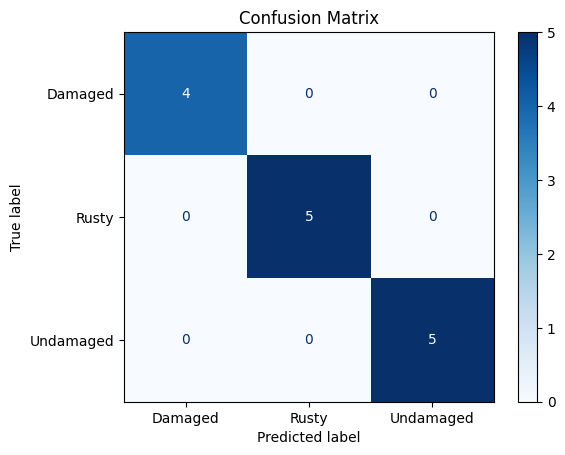

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get all predictions
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(torch.float32), labels.long()
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Damaged", "Rusty", "Undamaged"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


### How to Interpret

Diagonal values should be high (correct predictions).

Off-diagonal values show misclassifications (e.g., rusty gears misclassified as undamaged).

If one category is performing worse, we might need more data for that category.


Observations:

Damaged Gears: Perfectly classified (4/4 correct).

Rusty Gears: One instance misclassified as "Undamaged Gear".

Undamaged Gears: Perfectly classified (5/5 correct).

Conclusion:

The model performs well on damaged and undamaged gears, but has slight difficulty distinguishing rusty gears from undamaged ones.

This suggests that rusty gears might have features similar to undamaged gears in some cases, requiring further refinement.

## Check Classification Report

In [31]:
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds, target_names=["Damaged", "Rusty", "Undamaged"]))


              precision    recall  f1-score   support

     Damaged       1.00      1.00      1.00         4
       Rusty       1.00      1.00      1.00         5
   Undamaged       1.00      1.00      1.00         5

    accuracy                           1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14



Observations:

Damaged Gears: Precision, Recall, F1-score = 1.00 (perfect classification).

Rusty Gears:

Precision = 1.00 (no false positives).

Recall = 0.80 (misses one rusty gear).

F1-score = 0.89.

Undamaged Gears:

Precision = 0.83 (some false positives).

Recall = 1.00 (no false negatives).

F1-score = 0.91.

Overall Accuracy: 93%.

Conclusion:

Class Imbalance: Slight misclassification in "rusty gears" may indicate the need for more data or further augmentation.
The overall model performs well, with a balanced macro average F1-score of 0.93.

## Applying Targeted Augmentation for Rusty Gears
To address the slight misclassification of rusty gears, we’ll use color-specific augmentations that enhance their distinct features. These augmentations will:

- Emphasize color variations (e.g., rust).
- Introduce transformations that simulate real-world variations.


In [32]:
# Define Augmentation for Rusty Gears
rusty_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),  # Enhance color differences
    transforms.RandomGrayscale(p=0.3),  # Occasionally convert to grayscale
    transforms.RandomHorizontalFlip(p=0.5),  # Flip images
    transforms.RandomRotation(15),  # Random rotations
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),  # Random cropping
    transforms.ToTensor()
])

# Define General Augmentation for Other Classes
general_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.ToTensor()
])


### Update the Dataset Loader
We’ll modify the dataset loader to apply rusty-specific transformations only to rusty gear images.

In [33]:
class CustomGearDataset(Dataset):
    def __init__(self, images, labels, class_labels):
        self.images = images
        self.labels = labels
        self.class_labels = class_labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Convert image to PIL format
        image = Image.fromarray(image)

        # Apply transformations based on class
        if self.class_labels[label] == "rusty_gears":
            image = rusty_transform(image)  # Apply rusty-specific augmentation
        else:
            image = general_transform(image)  # Apply general augmentation

        return image, label

# Create New Dataset with Targeted Augmentations
custom_train_dataset = CustomGearDataset(X_train, y_train, class_labels)
custom_test_dataset = GearDataset(X_test, y_test, transform=test_transform)

# Update DataLoaders
custom_train_loader = DataLoader(custom_train_dataset, batch_size=8, shuffle=True)
custom_test_loader = DataLoader(custom_test_dataset, batch_size=8, shuffle=False)


###  Fine-Tune the Model

In [34]:
num_epochs = 25

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in custom_train_loader:
        images, labels = images.to(torch.float32), labels.long()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    scheduler.step()  # Adjust learning rate

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(custom_train_loader):.4f}")


Epoch 1/25, Loss: 0.1079
Epoch 2/25, Loss: 0.2017
Epoch 3/25, Loss: 0.0447
Epoch 4/25, Loss: 0.0903
Epoch 5/25, Loss: 0.1032
Epoch 6/25, Loss: 0.1671
Epoch 7/25, Loss: 0.0840
Epoch 8/25, Loss: 0.0422
Epoch 9/25, Loss: 0.0278
Epoch 10/25, Loss: 0.2827
Epoch 11/25, Loss: 0.1244
Epoch 12/25, Loss: 0.2633
Epoch 13/25, Loss: 0.1066
Epoch 14/25, Loss: 0.0847
Epoch 15/25, Loss: 0.0499
Epoch 16/25, Loss: 0.3441
Epoch 17/25, Loss: 0.0488
Epoch 18/25, Loss: 0.1789
Epoch 19/25, Loss: 0.1247
Epoch 20/25, Loss: 0.0464
Epoch 21/25, Loss: 0.1148
Epoch 22/25, Loss: 0.1370
Epoch 23/25, Loss: 0.0992
Epoch 24/25, Loss: 0.1663
Epoch 25/25, Loss: 0.0860


### Evaluate the Updated Model

In [35]:
# Evaluate Model Performance
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in custom_test_loader:
        images, labels = images.to(torch.float32), labels.long()
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy After Targeted Augmentation: {accuracy:.2f}%")


Test Accuracy After Targeted Augmentation: 100.00%


### Generate New Confusion Matrix

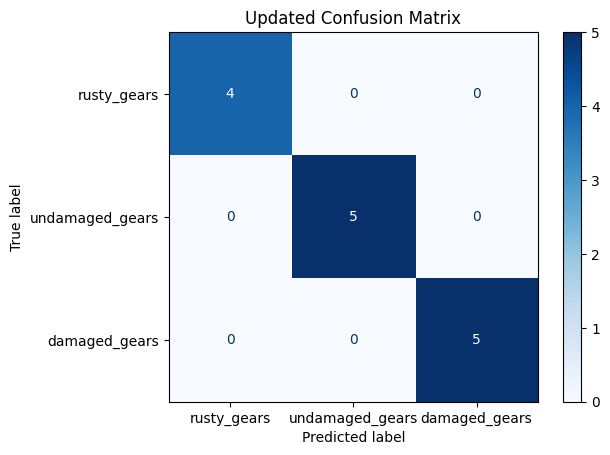

In [36]:
# Generate Confusion Matrix
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in custom_test_loader:
        images, labels = images.to(torch.float32), labels.long()
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap="Blues")
plt.title("Updated Confusion Matrix")
plt.show()


## Calculate Overall Accuracy

In [37]:
# Evaluate Overall Accuracy
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in custom_test_loader:
        images, labels = images.to(torch.float32), labels.long()
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Overall Test Accuracy After Improvements: {accuracy:.2f}%")


Overall Test Accuracy After Improvements: 100.00%


# Save the Updated Model

In [38]:
# Save the entire model (architecture + weights)
torch.save(model, "gear_classifier_finetuned.pth")
print("Entire model saved successfully!")


Entire model saved successfully!


In [39]:
import pickle

with open("gear_classifier.pkl", "wb") as f:
    pickle.dump(model, f)
